## Data Loading

In [1]:
# import os
# from PIL import Image, ImageOps
# from tqdm import tqdm  # ✅ Added progress bar

# # Source and destination directories
# src_root = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset"
# dst_root = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset_512_512"

# # Target size
# target_size = (512, 512)

# # Helper function: resize with padding (aspect-ratio preserved)
# def resize_with_padding(img, target_size, is_mask=False):
#     if is_mask and img.mode != "L":
#         img = img.convert("L")
#     elif not is_mask and img.mode != "RGB":
#         img = img.convert("RGB")

#     img = ImageOps.pad(
#         img,
#         target_size,
#         method=Image.NEAREST if is_mask else Image.BILINEAR,
#         color=0,
#         centering=(0.5, 0.5)
#     )
#     return img

# # Process all splits
# splits = ["train", "val", "test"]
# for split in splits:
#     for subfolder in ["images", "masks"]:
#         src_dir = os.path.join(src_root, split, subfolder)
#         dst_dir = os.path.join(dst_root, split, subfolder)
#         os.makedirs(dst_dir, exist_ok=True)

#         file_list = [
#             f for f in os.listdir(src_dir)
#             if f.lower().endswith((".png", ".jpg", ".jpeg"))
#         ]

#         print(f"🔄 Processing {split}/{subfolder} ({len(file_list)} files)...")
#         for fname in tqdm(file_list, desc=f"{split}/{subfolder}"):
#             src_path = os.path.join(src_dir, fname)
#             dst_path = os.path.join(dst_dir, fname)

#             with Image.open(src_path) as img:
#                 resized = resize_with_padding(img, target_size, is_mask=(subfolder == "masks"))
#                 resized.save(dst_path)

# print("✅ All images and masks resized to 512x512 with padding. Saved to:", dst_root)

In [2]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import numpy as np
import torch
from torchvision import transforms

class SegformerSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_size=512):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size

        self.filenames = sorted([
            f for f in os.listdir(image_dir)
            if f.lower().endswith(('.jpg', '.png', '.jpeg'))
        ])

        self.img_transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0,1] float32
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        image_name = self.filenames[idx]
        image_path = os.path.join(self.image_dir, image_name)
        mask_path = os.path.join(self.mask_dir, os.path.splitext(image_name)[0] + ".png")

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        # Convert mask to label ids
        mask = np.array(mask, dtype=np.uint8)
        mask = np.where(mask == 255, 2, np.where(mask == 127, 1, 0))

        image = self.img_transform(image)
        mask = torch.from_numpy(mask).long()

        return image, mask

In [3]:
# Root path to resized dataset
base_path = r"C:\Users\SHREY\Desktop\gnctd\segmentation_dataset_512_512"

# Datasets
train_dataset = SegformerSegmentationDataset(
    image_dir=os.path.join(base_path, "train", "images"),
    mask_dir=os.path.join(base_path, "train", "masks"),
)

val_dataset = SegformerSegmentationDataset(
    image_dir=os.path.join(base_path, "val", "images"),
    mask_dir=os.path.join(base_path, "val", "masks"),
)

test_dataset = SegformerSegmentationDataset(
    image_dir=os.path.join(base_path, "test", "images"),
    mask_dir=os.path.join(base_path, "test", "masks"),
)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

## Training

In [4]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

# Number of classes in your dataset
NUM_CLASSES = 3

# Load SegFormer-B0 configuration and model
config = SegformerConfig.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    num_labels=NUM_CLASSES,
    id2label={0: "background", 1: "crack", 2: "pothole"},
    label2id={"background": 0, "crack": 1, "pothole": 2}
)

model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b0-finetuned-ade-512-512",
    config=config,
    ignore_mismatched_sizes=True  # Useful if ADE has 150 classes and you have 3
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
import torch.nn as nn
import torch.optim as optim

# ⚖️ Class weights for handling imbalance: [background, crack, pothole]
class_weights = torch.tensor([0.1, 2.0, 1.5]).to(device)
# class_weights = torch.tensor([0.1, 4.0, 1.5]).to(device) #updated after 30 epochs, class 1 - .32 and class 2 -.73
# class_weights = torch.tensor([0.1, 7.0, 1.0]).to(device)

# 🔥 Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# 🚀 Optimizer setup
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

In [6]:
import torch
import torch.nn.functional as F
from tqdm import tqdm
import os
import time
import matplotlib.pyplot as plt
import csv
from sklearn.metrics import confusion_matrix
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_model(
    model, train_loader, val_loader, criterion, optimizer,
    num_epochs=10,
    save_path="best_model.pth",
    last_model_path="last_model.pth",
    checkpoint_path="checkpoint.pth",
    pause_file="pause.flag"
):
    start_epoch = 0
    best_miou = -1.0
    miou_list = []
    dice_list = []

    # Resume from checkpoint if exists
    if os.path.exists(checkpoint_path):
        print("🔁 Resuming from checkpoint...")
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        best_miou = checkpoint.get('best_miou', -1.0)
        print(f"➡️ Resumed from epoch {start_epoch}, Best mIoU so far: {best_miou:.4f}")

    model.to(device)
    print(f"📟 Using device: {device}")

    for epoch in range(start_epoch, num_epochs):
        while os.path.exists(pause_file):
            print("⏸️ Training paused. Remove 'pause.flag' to resume.")
            time.sleep(5)

        model.train()
        train_loss = 0.0
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] Training", leave=False)

        for images, masks in loop:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(pixel_values=images)
            import torch.nn.functional as F
            logits = F.interpolate(outputs.logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
            loss = criterion(logits, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        print(f"\n📘 Epoch {epoch+1}: Avg Train Loss = {avg_train_loss:.4f}")

        val_loss, miou, dice, ious, dices = validate(model, val_loader, criterion)

        miou_list.append(miou)
        dice_list.append(dice)

        if miou > best_miou:
            best_miou = miou
            torch.save(model.state_dict(), save_path)
            print(f"✅ Best model saved! mIoU = {best_miou:.4f}")

        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_miou': best_miou
        }, checkpoint_path)
        print(f"💾 Checkpoint saved at epoch {epoch+1}")

    torch.save(model.state_dict(), last_model_path)
    print(f"📦 Final model saved to: {last_model_path}")

    # Plotting
    plt.figure(figsize=(10, 5))
    plt.plot(miou_list, label="mIoU", marker='o')
    plt.plot(dice_list, label="Dice", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("mIoU and Dice over Epochs")
    plt.legend()
    plt.grid(True)
    plt.savefig("training_metrics.png")
    plt.show()

    with open("metrics_log.csv", "w", newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Epoch", "mIoU", "Dice"])
        for epoch, (m, d) in enumerate(zip(miou_list, dice_list), start=1):
            writer.writerow([epoch, m, d])

def compute_iou_and_dice(preds, labels, num_classes=3):
    preds = preds.flatten()
    labels = labels.flatten()
    cm = confusion_matrix(labels, preds, labels=range(num_classes))

    ious, dices = [], []
    for cls in range(num_classes):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom_iou = tp + fp + fn
        denom_dice = 2 * tp + fp + fn

        iou = tp / denom_iou if denom_iou > 0 else 0
        dice = (2 * tp) / denom_dice if denom_dice > 0 else 0

        ious.append(iou)
        dices.append(dice)

    return ious, dices, np.mean(ious), np.mean(dices)

@torch.no_grad()
def validate(model, val_loader, criterion, num_classes=3):
    model.eval()
    val_loss = 0.0
    all_preds, all_labels = [], []

    for images, masks in tqdm(val_loader, desc="🔍 Validating", leave=False):
        images, masks = images.to(device), masks.to(device)
        outputs = model(pixel_values=images)
        logits = F.interpolate(outputs.logits, size=masks.shape[-2:], mode="bilinear", align_corners=False)
        loss = criterion(logits, masks)
        val_loss += loss.item()
        
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_preds.append(preds)
        all_labels.append(masks.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    ious, dices, miou, mdice = compute_iou_and_dice(all_preds, all_labels, num_classes=num_classes)

    print(f"🔎 Val Loss: {avg_val_loss:.4f}, mIoU: {miou:.4f}, Dice: {mdice:.4f}")
    for idx, (iou, dice) in enumerate(zip(ious, dices)):
        print(f"🧾 Class {idx}: IoU = {iou:.4f}, Dice = {dice:.4f}")

    return avg_val_loss, miou, mdice, ious, dices

## Start Training

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_19232\470420776.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 30, Best mIoU so far: 0.5839
📟 Using device: cuda
📦 Final model saved to: segformer_last.pth


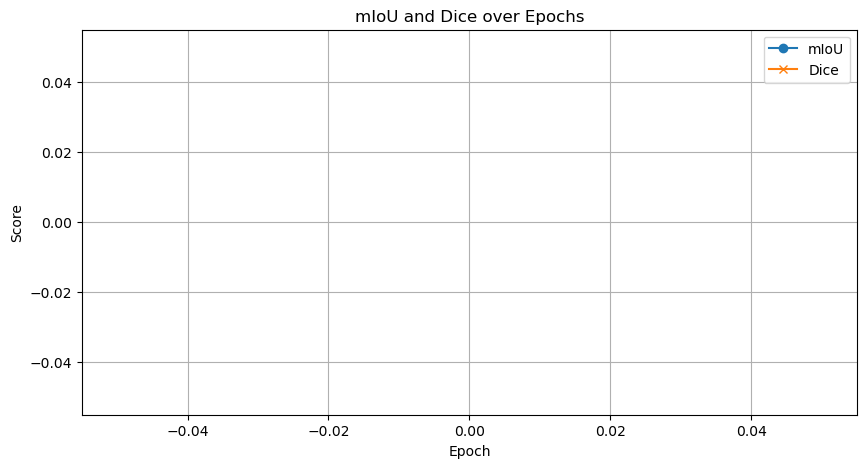

In [24]:
train_model(
    model=model,  # SegformerForSemanticSegmentation model
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=5,
    save_path="segformer_best.pth",
    last_model_path="segformer_last.pth",
    checkpoint_path="segformer_checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_19232\470420776.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 5, Best mIoU so far: 0.4912
📟 Using device: cuda



📘 Epoch 6: Avg Train Loss = 0.1007


🔎 Val Loss: 0.1085, mIoU: 0.4912, Dice: 0.5917
🧾 Class 0: IoU = 0.9719, Dice = 0.9857
🧾 Class 1: IoU = 0.1716, Dice = 0.2929
🧾 Class 2: IoU = 0.3303, Dice = 0.4966
✅ Best model saved! mIoU = 0.4912
💾 Checkpoint saved at epoch 6



📘 Epoch 7: Avg Train Loss = 0.0937


🔎 Val Loss: 0.1071, mIoU: 0.5307, Dice: 0.6362
🧾 Class 0: IoU = 0.9792, Dice = 0.9895
🧾 Class 1: IoU = 0.2038, Dice = 0.3386
🧾 Class 2: IoU = 0.4090, Dice = 0.5805
✅ Best model saved! mIoU = 0.5307
💾 Checkpoint saved at epoch 7



📘 Epoch 8: Avg Train Loss = 0.0902


🔎 Val Loss: 0.1071, mIoU: 0.5405, Dice: 0.6442
🧾 Class 0: IoU = 0.9772, Dice = 0.9885
🧾 Class 1: IoU = 0.1899, Dice = 0.3191
🧾 Class 2: IoU = 0.4544, Dice = 0.6249
✅ Best model saved! mIoU = 0.5405
💾 Checkpoint saved at epoch 8



📘 Epoch 9: Avg Train Loss = 0.0899


🔎 Val Loss: 0.0993, mIoU: 0.5117, Dice: 0.6150
🧾 Class 0: IoU = 0.9748, Dice = 0.9872
🧾 Class 1: IoU = 0.1837, Dice = 0.3104
🧾 Class 2: IoU = 0.3767, Dice = 0.5473
💾 Checkpoint saved at epoch 9



📘 Epoch 10: Avg Train Loss = 0.0854


🔎 Val Loss: 0.1002, mIoU: 0.5271, Dice: 0.6277
🧾 Class 0: IoU = 0.9705, Dice = 0.9850
🧾 Class 1: IoU = 0.1617, Dice = 0.2784
🧾 Class 2: IoU = 0.4490, Dice = 0.6197
💾 Checkpoint saved at epoch 10
📦 Final model saved to: segformer_last.pth


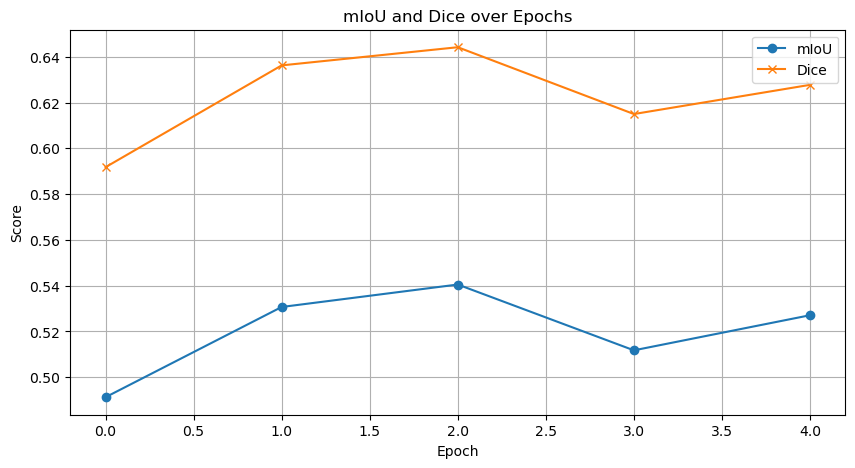

In [16]:
train_model(
    model=model,  # SegformerForSemanticSegmentation model
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=10,
    save_path="segformer_best.pth",
    last_model_path="segformer_last.pth",
    checkpoint_path="segformer_checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_19232\470420776.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 10, Best mIoU so far: 0.5405
📟 Using device: cuda



📘 Epoch 11: Avg Train Loss = 0.0823


🔎 Val Loss: 0.1025, mIoU: 0.5247, Dice: 0.6271
🧾 Class 0: IoU = 0.9735, Dice = 0.9866
🧾 Class 1: IoU = 0.1745, Dice = 0.2972
🧾 Class 2: IoU = 0.4261, Dice = 0.5976
💾 Checkpoint saved at epoch 11



📘 Epoch 12: Avg Train Loss = 0.0807


🔎 Val Loss: 0.1006, mIoU: 0.5607, Dice: 0.6647
🧾 Class 0: IoU = 0.9794, Dice = 0.9896
🧾 Class 1: IoU = 0.2039, Dice = 0.3388
🧾 Class 2: IoU = 0.4989, Dice = 0.6657
✅ Best model saved! mIoU = 0.5607
💾 Checkpoint saved at epoch 12



📘 Epoch 13: Avg Train Loss = 0.0788


🔎 Val Loss: 0.1024, mIoU: 0.5656, Dice: 0.6686
🧾 Class 0: IoU = 0.9795, Dice = 0.9896
🧾 Class 1: IoU = 0.2022, Dice = 0.3364
🧾 Class 2: IoU = 0.5150, Dice = 0.6799
✅ Best model saved! mIoU = 0.5656
💾 Checkpoint saved at epoch 13



📘 Epoch 14: Avg Train Loss = 0.0778


🔎 Val Loss: 0.0975, mIoU: 0.5501, Dice: 0.6506
🧾 Class 0: IoU = 0.9738, Dice = 0.9867
🧾 Class 1: IoU = 0.1739, Dice = 0.2963
🧾 Class 2: IoU = 0.5025, Dice = 0.6688
💾 Checkpoint saved at epoch 14



📘 Epoch 15: Avg Train Loss = 0.0778


🔎 Val Loss: 0.1061, mIoU: 0.5599, Dice: 0.6630
🧾 Class 0: IoU = 0.9785, Dice = 0.9891
🧾 Class 1: IoU = 0.1974, Dice = 0.3297
🧾 Class 2: IoU = 0.5038, Dice = 0.6700
💾 Checkpoint saved at epoch 15



📘 Epoch 16: Avg Train Loss = 0.0809


🔎 Val Loss: 0.1040, mIoU: 0.5235, Dice: 0.6297
🧾 Class 0: IoU = 0.9798, Dice = 0.9898
🧾 Class 1: IoU = 0.2127, Dice = 0.3508
🧾 Class 2: IoU = 0.3780, Dice = 0.5486
💾 Checkpoint saved at epoch 16



📘 Epoch 17: Avg Train Loss = 0.0772


🔎 Val Loss: 0.1113, mIoU: 0.5514, Dice: 0.6539
🧾 Class 0: IoU = 0.9765, Dice = 0.9881
🧾 Class 1: IoU = 0.1868, Dice = 0.3148
🧾 Class 2: IoU = 0.4911, Dice = 0.6587
💾 Checkpoint saved at epoch 17



📘 Epoch 18: Avg Train Loss = 0.0873


🔎 Val Loss: 0.1100, mIoU: 0.5335, Dice: 0.6380
🧾 Class 0: IoU = 0.9777, Dice = 0.9887
🧾 Class 1: IoU = 0.1945, Dice = 0.3257
🧾 Class 2: IoU = 0.4282, Dice = 0.5997
💾 Checkpoint saved at epoch 18



📘 Epoch 19: Avg Train Loss = 0.0758


🔎 Val Loss: 0.0961, mIoU: 0.5292, Dice: 0.6338
🧾 Class 0: IoU = 0.9766, Dice = 0.9882
🧾 Class 1: IoU = 0.1929, Dice = 0.3234
🧾 Class 2: IoU = 0.4182, Dice = 0.5898
💾 Checkpoint saved at epoch 19



📘 Epoch 20: Avg Train Loss = 0.0736


🔎 Val Loss: 0.0980, mIoU: 0.5407, Dice: 0.6435
🧾 Class 0: IoU = 0.9751, Dice = 0.9874
🧾 Class 1: IoU = 0.1827, Dice = 0.3089
🧾 Class 2: IoU = 0.4642, Dice = 0.6341
💾 Checkpoint saved at epoch 20



📘 Epoch 21: Avg Train Loss = 0.0721


🔎 Val Loss: 0.1058, mIoU: 0.5766, Dice: 0.6786
🧾 Class 0: IoU = 0.9799, Dice = 0.9899
🧾 Class 1: IoU = 0.2053, Dice = 0.3407
🧾 Class 2: IoU = 0.5446, Dice = 0.7052
✅ Best model saved! mIoU = 0.5766
💾 Checkpoint saved at epoch 21



📘 Epoch 22: Avg Train Loss = 0.0723


🔎 Val Loss: 0.1104, mIoU: 0.5524, Dice: 0.6542
🧾 Class 0: IoU = 0.9759, Dice = 0.9878
🧾 Class 1: IoU = 0.1835, Dice = 0.3101
🧾 Class 2: IoU = 0.4976, Dice = 0.6646
💾 Checkpoint saved at epoch 22



📘 Epoch 23: Avg Train Loss = 0.0760


🔎 Val Loss: 0.1181, mIoU: 0.5573, Dice: 0.6601
🧾 Class 0: IoU = 0.9779, Dice = 0.9888
🧾 Class 1: IoU = 0.1940, Dice = 0.3249
🧾 Class 2: IoU = 0.4999, Dice = 0.6666
💾 Checkpoint saved at epoch 23



📘 Epoch 24: Avg Train Loss = 0.0718


🔎 Val Loss: 0.1047, mIoU: 0.5644, Dice: 0.6687
🧾 Class 0: IoU = 0.9803, Dice = 0.9901
🧾 Class 1: IoU = 0.2099, Dice = 0.3470
🧾 Class 2: IoU = 0.5029, Dice = 0.6692
💾 Checkpoint saved at epoch 24



📘 Epoch 25: Avg Train Loss = 0.0706


🔎 Val Loss: 0.1025, mIoU: 0.5770, Dice: 0.6778
🧾 Class 0: IoU = 0.9787, Dice = 0.9892
🧾 Class 1: IoU = 0.1988, Dice = 0.3316
🧾 Class 2: IoU = 0.5534, Dice = 0.7125
✅ Best model saved! mIoU = 0.5770
💾 Checkpoint saved at epoch 25



📘 Epoch 26: Avg Train Loss = 0.0692


🔎 Val Loss: 0.0949, mIoU: 0.5665, Dice: 0.6673
🧾 Class 0: IoU = 0.9768, Dice = 0.9883
🧾 Class 1: IoU = 0.1889, Dice = 0.3178
🧾 Class 2: IoU = 0.5337, Dice = 0.6959
💾 Checkpoint saved at epoch 26



📘 Epoch 27: Avg Train Loss = 0.0709


🔎 Val Loss: 0.1109, mIoU: 0.5562, Dice: 0.6566
🧾 Class 0: IoU = 0.9746, Dice = 0.9871
🧾 Class 1: IoU = 0.1772, Dice = 0.3010
🧾 Class 2: IoU = 0.5169, Dice = 0.6816
💾 Checkpoint saved at epoch 27



📘 Epoch 28: Avg Train Loss = 0.0697


🔎 Val Loss: 0.1118, mIoU: 0.5646, Dice: 0.6666
🧾 Class 0: IoU = 0.9779, Dice = 0.9888
🧾 Class 1: IoU = 0.1941, Dice = 0.3251
🧾 Class 2: IoU = 0.5219, Dice = 0.6859
💾 Checkpoint saved at epoch 28



📘 Epoch 29: Avg Train Loss = 0.0679


🔎 Val Loss: 0.1017, mIoU: 0.5757, Dice: 0.6767
🧾 Class 0: IoU = 0.9788, Dice = 0.9893
🧾 Class 1: IoU = 0.1989, Dice = 0.3318
🧾 Class 2: IoU = 0.5493, Dice = 0.7091
💾 Checkpoint saved at epoch 29



📘 Epoch 30: Avg Train Loss = 0.0688


🔎 Val Loss: 0.1010, mIoU: 0.5839, Dice: 0.6830
🧾 Class 0: IoU = 0.9783, Dice = 0.9890
🧾 Class 1: IoU = 0.1960, Dice = 0.3278
🧾 Class 2: IoU = 0.5774, Dice = 0.7321
✅ Best model saved! mIoU = 0.5839
💾 Checkpoint saved at epoch 30
📦 Final model saved to: segformer_last.pth


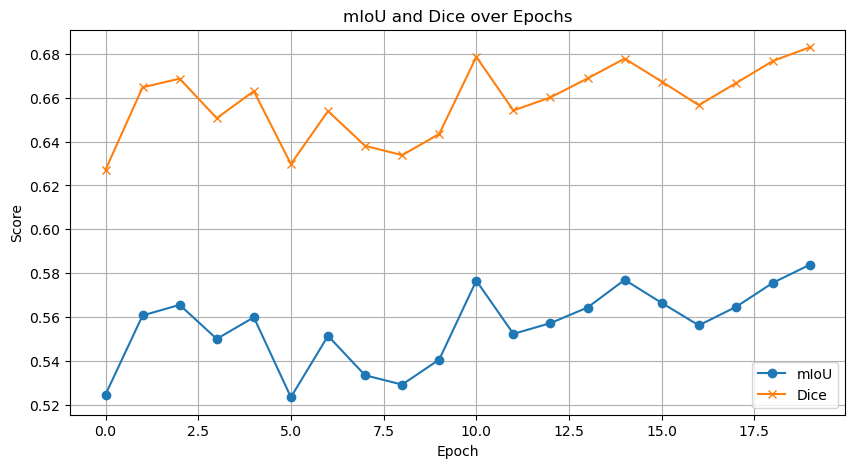

In [17]:
train_model(
    model=model,  # SegformerForSemanticSegmentation model
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=30,
    save_path="segformer_best.pth",
    last_model_path="segformer_last.pth",
    checkpoint_path="segformer_checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_19232\470420776.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 30, Best mIoU so far: 0.5839
📟 Using device: cuda



📘 Epoch 31: Avg Train Loss = 0.0835


🔎 Val Loss: 0.1404, mIoU: 0.5285, Dice: 0.6290
🧾 Class 0: IoU = 0.9709, Dice = 0.9853
🧾 Class 1: IoU = 0.1618, Dice = 0.2785
🧾 Class 2: IoU = 0.4528, Dice = 0.6233
💾 Checkpoint saved at epoch 31



📘 Epoch 32: Avg Train Loss = 0.0829


🔎 Val Loss: 0.1143, mIoU: 0.5632, Dice: 0.6568
🧾 Class 0: IoU = 0.9670, Dice = 0.9832
🧾 Class 1: IoU = 0.1474, Dice = 0.2569
🧾 Class 2: IoU = 0.5751, Dice = 0.7302
💾 Checkpoint saved at epoch 32



📘 Epoch 33: Avg Train Loss = 0.0837


🔎 Val Loss: 0.1282, mIoU: 0.5294, Dice: 0.6290
🧾 Class 0: IoU = 0.9689, Dice = 0.9842
🧾 Class 1: IoU = 0.1551, Dice = 0.2686
🧾 Class 2: IoU = 0.4643, Dice = 0.6342
💾 Checkpoint saved at epoch 33



📘 Epoch 34: Avg Train Loss = 0.1010


🔎 Val Loss: 0.1219, mIoU: 0.5513, Dice: 0.6493
🧾 Class 0: IoU = 0.9707, Dice = 0.9851
🧾 Class 1: IoU = 0.1598, Dice = 0.2756
🧾 Class 2: IoU = 0.5233, Dice = 0.6870
💾 Checkpoint saved at epoch 34



📘 Epoch 35: Avg Train Loss = 0.0906


🔎 Val Loss: 0.1184, mIoU: 0.5553, Dice: 0.6520
🧾 Class 0: IoU = 0.9696, Dice = 0.9846
🧾 Class 1: IoU = 0.1561, Dice = 0.2700
🧾 Class 2: IoU = 0.5401, Dice = 0.7014
💾 Checkpoint saved at epoch 35



📘 Epoch 36: Avg Train Loss = 0.0843


🔎 Val Loss: 0.1264, mIoU: 0.5730, Dice: 0.6702
🧾 Class 0: IoU = 0.9742, Dice = 0.9869
🧾 Class 1: IoU = 0.1748, Dice = 0.2976
🧾 Class 2: IoU = 0.5699, Dice = 0.7260
💾 Checkpoint saved at epoch 36



📘 Epoch 37: Avg Train Loss = 0.0806


🔎 Val Loss: 0.1174, mIoU: 0.5599, Dice: 0.6556
🧾 Class 0: IoU = 0.9690, Dice = 0.9843
🧾 Class 1: IoU = 0.1545, Dice = 0.2677
🧾 Class 2: IoU = 0.5562, Dice = 0.7148
💾 Checkpoint saved at epoch 37



📘 Epoch 38: Avg Train Loss = 0.0802


🔎 Val Loss: 0.1292, mIoU: 0.5758, Dice: 0.6738
🧾 Class 0: IoU = 0.9755, Dice = 0.9876
🧾 Class 1: IoU = 0.1818, Dice = 0.3076
🧾 Class 2: IoU = 0.5700, Dice = 0.7261
💾 Checkpoint saved at epoch 38



📘 Epoch 39: Avg Train Loss = 0.0786


🔎 Val Loss: 0.1186, mIoU: 0.5490, Dice: 0.6482
🧾 Class 0: IoU = 0.9712, Dice = 0.9854
🧾 Class 1: IoU = 0.1646, Dice = 0.2827
🧾 Class 2: IoU = 0.5113, Dice = 0.6766
💾 Checkpoint saved at epoch 39



📘 Epoch 40: Avg Train Loss = 0.0785


🔎 Val Loss: 0.1273, mIoU: 0.5767, Dice: 0.6719
🧾 Class 0: IoU = 0.9728, Dice = 0.9862
🧾 Class 1: IoU = 0.1682, Dice = 0.2880
🧾 Class 2: IoU = 0.5890, Dice = 0.7414
💾 Checkpoint saved at epoch 40
📦 Final model saved to: segformer_last.pth


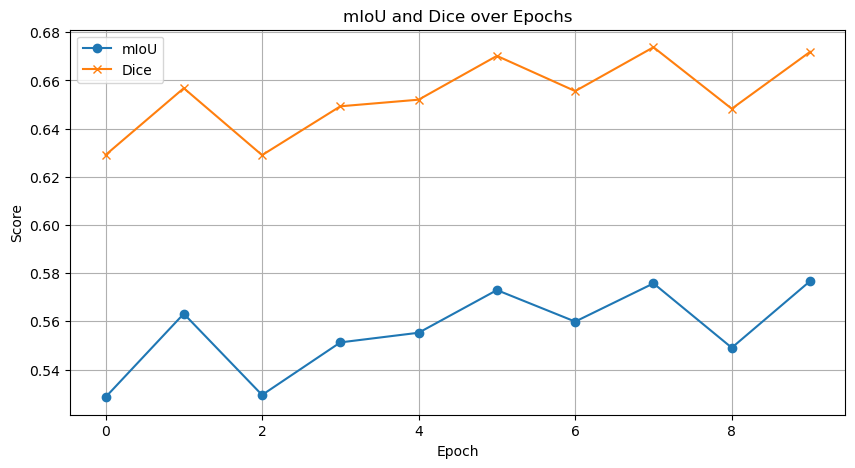

In [25]:
train_model(
    model=model,  # SegformerForSemanticSegmentation model
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=40,
    save_path="segformer_best.pth",
    last_model_path="segformer_last.pth",
    checkpoint_path="segformer_checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_19232\470420776.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 45, Best mIoU so far: 0.5839
📟 Using device: cuda



📘 Epoch 46: Avg Train Loss = 0.0647


🔎 Val Loss: 0.1056, mIoU: 0.5933, Dice: 0.6934
🧾 Class 0: IoU = 0.9810, Dice = 0.9904
🧾 Class 1: IoU = 0.2128, Dice = 0.3509
🧾 Class 2: IoU = 0.5861, Dice = 0.7390
✅ Best model saved! mIoU = 0.5933
💾 Checkpoint saved at epoch 46



📘 Epoch 47: Avg Train Loss = 0.0629


🔎 Val Loss: 0.1071, mIoU: 0.5866, Dice: 0.6871
🧾 Class 0: IoU = 0.9801, Dice = 0.9899
🧾 Class 1: IoU = 0.2072, Dice = 0.3432
🧾 Class 2: IoU = 0.5726, Dice = 0.7282
💾 Checkpoint saved at epoch 47



📘 Epoch 48: Avg Train Loss = 0.0627


🔎 Val Loss: 0.1031, mIoU: 0.5859, Dice: 0.6856
🧾 Class 0: IoU = 0.9791, Dice = 0.9895
🧾 Class 1: IoU = 0.2015, Dice = 0.3354
🧾 Class 2: IoU = 0.5770, Dice = 0.7318
💾 Checkpoint saved at epoch 48



📘 Epoch 49: Avg Train Loss = 0.0643


🔎 Val Loss: 0.1073, mIoU: 0.5829, Dice: 0.6835
🧾 Class 0: IoU = 0.9797, Dice = 0.9897
🧾 Class 1: IoU = 0.2036, Dice = 0.3383
🧾 Class 2: IoU = 0.5656, Dice = 0.7225
💾 Checkpoint saved at epoch 49



📘 Epoch 50: Avg Train Loss = 0.0633


🔎 Val Loss: 0.1136, mIoU: 0.5765, Dice: 0.6796
🧾 Class 0: IoU = 0.9807, Dice = 0.9903
🧾 Class 1: IoU = 0.2124, Dice = 0.3504
🧾 Class 2: IoU = 0.5363, Dice = 0.6982
💾 Checkpoint saved at epoch 50
📦 Final model saved to: segformer_last.pth


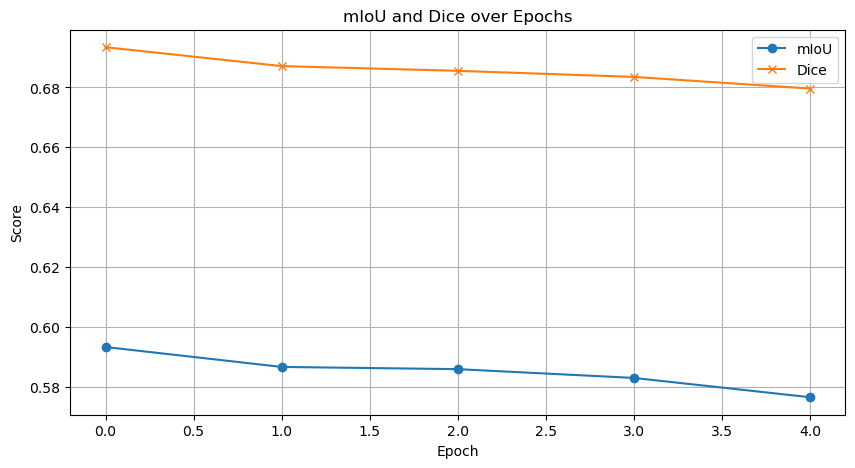

In [36]:
train_model(
    model=model,  # SegformerForSemanticSegmentation model
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50,
    save_path="segformer_best.pth",
    last_model_path="segformer_last.pth",
    checkpoint_path="segformer_checkpoint.pth"
)

🔁 Resuming from checkpoint...


C:\Users\SHREY\AppData\Local\Temp\ipykernel_19232\470420776.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device

➡️ Resumed from epoch 50, Best mIoU so far: 0.5933
📟 Using device: cuda



📘 Epoch 51: Avg Train Loss = 0.0627


🔎 Val Loss: 0.1031, mIoU: 0.5599, Dice: 0.6624
🧾 Class 0: IoU = 0.9775, Dice = 0.9886
🧾 Class 1: IoU = 0.1933, Dice = 0.3240
🧾 Class 2: IoU = 0.5090, Dice = 0.6746
💾 Checkpoint saved at epoch 51



📘 Epoch 52: Avg Train Loss = 0.0631


🔎 Val Loss: 0.1037, mIoU: 0.5773, Dice: 0.6773
🧾 Class 0: IoU = 0.9778, Dice = 0.9888
🧾 Class 1: IoU = 0.1940, Dice = 0.3249
🧾 Class 2: IoU = 0.5603, Dice = 0.7182
💾 Checkpoint saved at epoch 52



📘 Epoch 53: Avg Train Loss = 0.0636


🔎 Val Loss: 0.1056, mIoU: 0.5843, Dice: 0.6849
🧾 Class 0: IoU = 0.9795, Dice = 0.9897
🧾 Class 1: IoU = 0.2049, Dice = 0.3402
🧾 Class 2: IoU = 0.5683, Dice = 0.7247
💾 Checkpoint saved at epoch 53



📘 Epoch 54: Avg Train Loss = 0.0638


🔎 Val Loss: 0.1122, mIoU: 0.5719, Dice: 0.6764
🧾 Class 0: IoU = 0.9813, Dice = 0.9906
🧾 Class 1: IoU = 0.2171, Dice = 0.3568
🧾 Class 2: IoU = 0.5173, Dice = 0.6819
💾 Checkpoint saved at epoch 54



📘 Epoch 55: Avg Train Loss = 0.0630


🔎 Val Loss: 0.1063, mIoU: 0.5945, Dice: 0.6950
🧾 Class 0: IoU = 0.9817, Dice = 0.9908
🧾 Class 1: IoU = 0.2166, Dice = 0.3560
🧾 Class 2: IoU = 0.5851, Dice = 0.7383
✅ Best model saved! mIoU = 0.5945
💾 Checkpoint saved at epoch 55



📘 Epoch 56: Avg Train Loss = 0.0616


🔎 Val Loss: 0.1056, mIoU: 0.6007, Dice: 0.6988
🧾 Class 0: IoU = 0.9809, Dice = 0.9904
🧾 Class 1: IoU = 0.2107, Dice = 0.3481
🧾 Class 2: IoU = 0.6104, Dice = 0.7581
✅ Best model saved! mIoU = 0.6007
💾 Checkpoint saved at epoch 56



📘 Epoch 57: Avg Train Loss = 0.0619


🔎 Val Loss: 0.0991, mIoU: 0.5898, Dice: 0.6877
🧾 Class 0: IoU = 0.9783, Dice = 0.9890
🧾 Class 1: IoU = 0.1959, Dice = 0.3276
🧾 Class 2: IoU = 0.5953, Dice = 0.7463
💾 Checkpoint saved at epoch 57



📘 Epoch 58: Avg Train Loss = 0.0613


🔎 Val Loss: 0.1097, mIoU: 0.5983, Dice: 0.6970
🧾 Class 0: IoU = 0.9808, Dice = 0.9903
🧾 Class 1: IoU = 0.2107, Dice = 0.3481
🧾 Class 2: IoU = 0.6035, Dice = 0.7527
💾 Checkpoint saved at epoch 58



📘 Epoch 59: Avg Train Loss = 0.0619


🔎 Val Loss: 0.1166, mIoU: 0.5801, Dice: 0.6838
🧾 Class 0: IoU = 0.9818, Dice = 0.9908
🧾 Class 1: IoU = 0.2200, Dice = 0.3606
🧾 Class 2: IoU = 0.5385, Dice = 0.7000
💾 Checkpoint saved at epoch 59



📘 Epoch 60: Avg Train Loss = 0.0634


🔎 Val Loss: 0.1124, mIoU: 0.5771, Dice: 0.6780
🧾 Class 0: IoU = 0.9788, Dice = 0.9893
🧾 Class 1: IoU = 0.1994, Dice = 0.3324
🧾 Class 2: IoU = 0.5531, Dice = 0.7122
💾 Checkpoint saved at epoch 60
📦 Final model saved to: segformer_last.pth


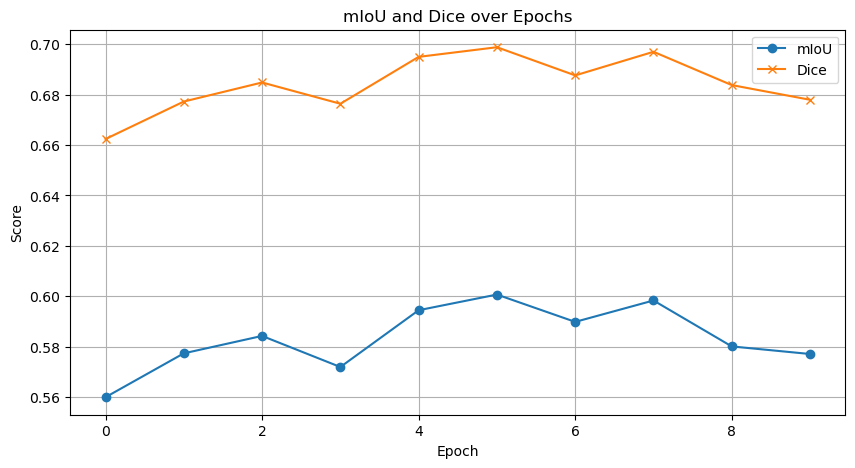

In [37]:
train_model(
    model=model,  # SegformerForSemanticSegmentation model
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=60,
    save_path="segformer_best.pth",
    last_model_path="segformer_last.pth",
    checkpoint_path="segformer_checkpoint.pth"
)

In [38]:
from sklearn.metrics import confusion_matrix
import numpy as np

def compute_confusion_metrics(preds, labels, num_classes=3):
    """
    preds and labels must be 1D arrays of class IDs.
    """
    cm = confusion_matrix(labels, preds, labels=range(num_classes))
    print("🔷 Confusion Matrix:")
    print(cm)

    per_class_accuracy = {}
    for cls in range(num_classes):
        tp = cm[cls, cls]
        total = cm[cls, :].sum()
        acc = tp / total if total > 0 else 0.0
        per_class_accuracy[cls] = acc

    return cm, per_class_accuracy


In [42]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(pixel_values=images)
            logits = torch.nn.functional.interpolate(
                outputs.logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
            )
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Plot confusion matrix
    # Standardized Confusion Matrix (Row-normalized)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("\n📋 Standardized Confusion Matrix (rows sum to 1):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    # Plot confusion matrix (standardized)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Standardized Confusion Matrix")
    plt.tight_layout()
    plt.show()


📊 Performance Metrics:
Pixel Accuracy: 0.9789
Per-class Accuracy:
  Background: 0.9805
  Crack: 0.8376
  Pothole: 0.6720
IoU per class:
  Background: 0.9791
  Crack: 0.1899
  Pothole: 0.5413
Mean IoU: 0.5701

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9805  0.0188  0.0007
Crack     : 0.1608  0.8376  0.0017
Pothole   : 0.1918  0.1362  0.6720


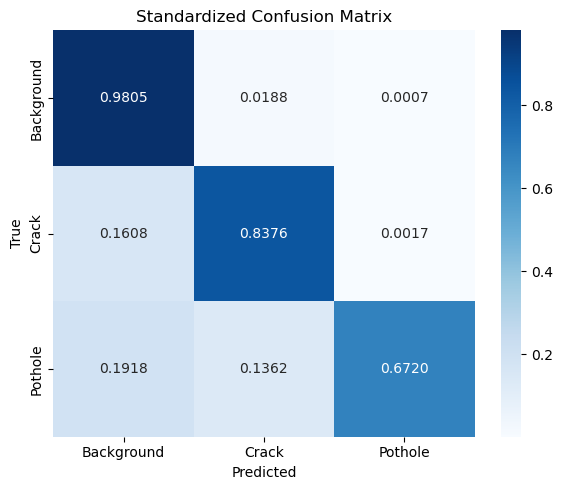

In [43]:
compute_metrics(model, test_loader, device)


## Final Evaluation

In [7]:
from tqdm import tqdm
import torch
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import SegformerForSemanticSegmentation, SegformerConfig

CLASS_NAMES = ["Background", "Crack", "Pothole"]
NUM_CLASSES = 3

def compute_metrics_from_path(model_path, dataloader, device):
    # Load SegFormer model
    config = SegformerConfig.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        num_labels=NUM_CLASSES,
        id2label={0: "background", 1: "crack", 2: "pothole"},
        label2id={"background": 0, "crack": 1, "pothole": 2}
    )
    model = SegformerForSemanticSegmentation.from_pretrained(
        "nvidia/segformer-b0-finetuned-ade-512-512",
        config=config,
        ignore_mismatched_sizes=True
    )
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="🔍 Evaluating", leave=False):
            images, masks = images.to(device), masks.to(device)
            outputs = model(pixel_values=images)
            logits = torch.nn.functional.interpolate(
                outputs.logits, size=masks.shape[-2:], mode="bilinear", align_corners=False
            )
            preds = torch.argmax(logits, dim=1)

            all_preds.extend(preds.cpu().numpy().flatten())
            all_labels.extend(masks.cpu().numpy().flatten())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    cm = confusion_matrix(all_labels, all_preds, labels=range(NUM_CLASSES))
    ious = []
    for cls in range(NUM_CLASSES):
        tp = cm[cls, cls]
        fp = cm[:, cls].sum() - tp
        fn = cm[cls, :].sum() - tp
        denom = tp + fp + fn
        iou = tp / denom if denom > 0 else 0
        ious.append(iou)

    pixel_acc = np.mean(all_preds == all_labels)
    per_class_acc = cm.diagonal() / cm.sum(axis=1)

    print("\n📊 Performance Metrics:")
    print(f"Pixel Accuracy: {pixel_acc:.4f}")
    print("Per-class Accuracy:")
    for i, acc in enumerate(per_class_acc):
        print(f"  {CLASS_NAMES[i]}: {acc:.4f}")
    print("IoU per class:")
    for i, iou in enumerate(ious):
        print(f"  {CLASS_NAMES[i]}: {iou:.4f}")
    print(f"Mean IoU: {np.mean(ious):.4f}")

    # Standardized Confusion Matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("\n📋 Standardized Confusion Matrix (rows sum to 1):")
    for i, row in enumerate(cm_normalized):
        row_str = '  '.join(f"{val:.4f}" for val in row)
        print(f"{CLASS_NAMES[i]:<10}: {row_str}")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_normalized, annot=True, fmt=".4f", xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Standardized Confusion Matrix")
    plt.tight_layout()
    plt.show()


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([3]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([3, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\SHREY\AppData\Local\Temp\ipykernel_13172\866305775.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). I


📊 Performance Metrics:
Pixel Accuracy: 0.9789
Per-class Accuracy:
  Background: 0.9805
  Crack: 0.8376
  Pothole: 0.6720
IoU per class:
  Background: 0.9791
  Crack: 0.1899
  Pothole: 0.5413
Mean IoU: 0.5701

📋 Standardized Confusion Matrix (rows sum to 1):
Background: 0.9805  0.0188  0.0007
Crack     : 0.1608  0.8376  0.0017
Pothole   : 0.1918  0.1362  0.6720


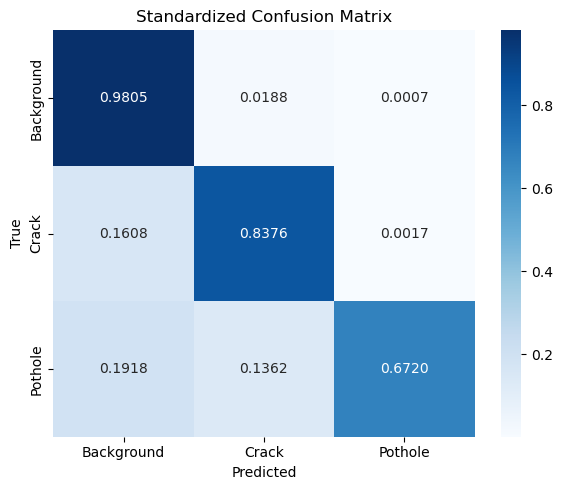

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_path = r"C:\Users\SHREY\Desktop\gnctd\segformer_last.pth"
compute_metrics_from_path(model_path, test_loader, device)